# Part 3: Train GPT-2

- This is Part 3 of building, optimizing, and training GPT-2 from scratch.  In this part, I'll train GPT-2-style transformer on the [Tiny Stories dataset](https://huggingface.co/datasets/roneneldan/TinyStories), which is a synthetic dataset of children's stories produced by Microsoft Research.  Since this dataset has shorter sequences and limited vocabulary, this is an opportunity to adjust both the tokenizer and the GPT-2 transformer to further speed up training.  To this end, I'll first train a Hugging Face tokenizer since OpenAI's original tiktoken tokenizer cannot be trained.  I'll also show how to adjust Andrej's code to be used with the Hugging Face tokenizer.  

## Training the tokenizer

- I'll first train the tokenizer using the method recommended by [Hugging Face](https://huggingface.co/learn/nlp-course/en/chapter6/2).  I may loop back to this to replicate it from scratch in a later notebook.

In [ ]:
from datasets import load_dataset
tiny_stories_ds=load_dataset("roneneldan/TinyStories")

def get_training_corpus(dataset,split='train',field='text'):
    dataset = dataset[split]
    for start_idx in range(0, len(dataset), 1024): #using a power of 2, why not...
        yield dataset[start_idx:start_idx+1024][field]
training_corpus = get_training_corpus(tiny_stories_ds)

from transformers import AutoTokenizer
old_tokenizer = AutoTokenizer.from_pretrained('gpt2')

tokenizer = old_tokenizer.train_new_from_iterator(training_corpus,vocab_size=6400) # don't forget to adjust the training script with this number!
tokenizer.save_pretrained('./tokenizer/tiny_stories_tokenizer')

- Most common words get encoded in a single token 

```tokenizer.encode(' dog'),tokenizer.encode(' girl'), tokenizer.encode(' bird'),tokenizer.encode(' dad'),tokenizer.encode(' mom'),tokenizer.encode(' cat'),tokenizer.encode(' Lily')```
yields 

```([634], [446], [537], [648], [365], [701], [364])```
- Note the presence of space before the common words: this is how GPT-2 encodes words by default. 

- Running some experiments on the tokenizer length, here are some statistics on a random subset of size 10000 tokenized with tokenizers with various vocabulary sizes:

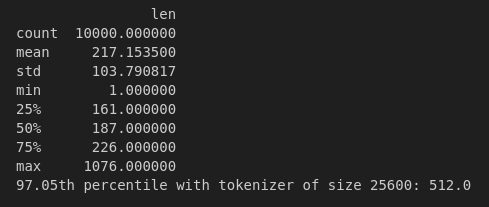

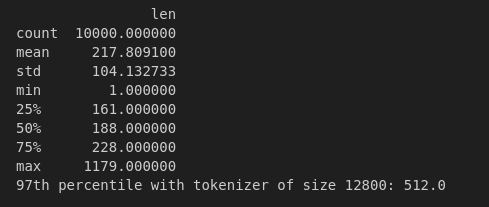

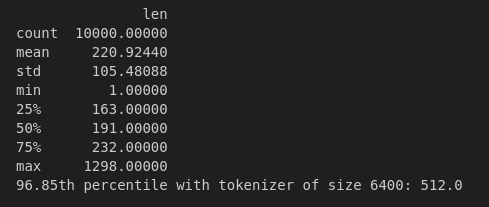

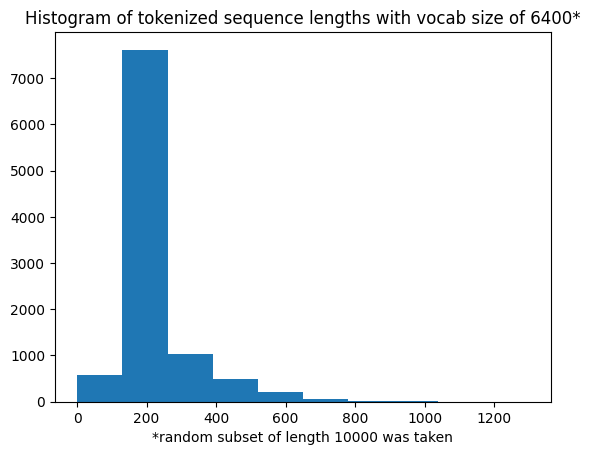

- As expected, as tokenizer size decreases, the average number of tokens per story increases and the distribution of tokens needed per story shifts to the rights slightly.  Regardless, almost 97% of the stories can be tokenized in their entirety by 512 tokens or less.  I thus choose to shrink the sequence length from 1024 to 512: critically, this will reduce the amount of memory taken by the embedding matrices and the activations, allowing me to use much bigger batch sizes per GPU (64 instead of 8 or 10) during training.  This leads to further memory speed-ups.  
    - Note that 512 is still a multiple of 32, agreeing with recommendations by both Andrej and [Anthony et al (2024)](https://arxiv.org/abs/2401.14489). 
    - Also, the model would be ~91M parameters rather than 126M parameters of the original GPT-2 small.
    - Shrinking *just* the vocab size but *not* the sequence length increases the training speed from 110K tokens/second with default GPT-2 setup from Part 2 to about 150K tokens/second.
    - Reducing both the vocab size *and* the sequence length further speeds up the training to 162K tokens/second, about 47% training speed-up overall.

- The *tinystories* dataset has 2.12M stories.  At about 200 tokens/story at vocab size of 6400, this makes for about 420M tokens.  With vocab size shrunk to 6400, I'm able to process batches of size 32 with 1024 tokens/batch per each of the two GPUs, I'm able to process 150K tokens/second, leading to about an 8-hour training run for a full pass through the data.

- In addition, 96.75% of the stories are under 512 tokens in length.  Reducing the sequence length to 512 allows us to increase the batch size to 64 and speeds up training to 162K tokens/second. 

In [ ]:
torchrun --standalone --nproc_per_node=2 train_gpt2.py 

- torchrun shows the following warning: "Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed."  I have 24 threads on my machine (can find this out with *nproc*), so setting *export OMP_NUM_THREADS=8* to let each GPU access 8 threads.

- Now 405M tokens (2.12M stories at 191 tokens/story on average) at 131072 (64 batch size/GPU x 512 sequence length x 2 GPUs) tokens processed/step would take at most 6200 steps for a full epoch. 

## Integrating the Hugging Face tokenizer with Andrej's code

- Inside fineweb.py, Andrej's setup and *tokenize* function are as follows:

In [ ]:
import tiktoken
fw = load_dataset("HuggingFaceFW/fineweb-edu", name=remote_name, split="train")
# init the tokenizer
enc = tiktoken.get_encoding("gpt2")
eot = enc._special_tokens['<|endoftext|>'] # end of text token
def tokenize(doc):
    # tokenizes a single document and returns a numpy array of uint16 tokens
    tokens = [eot] # the special <|endoftext|> token delimits all documents
    tokens.extend(enc.encode_ordinary(doc["text"]))
    tokens_np = np.array(tokens)
    assert (0 <= tokens_np).all() and (tokens_np < 2**16).all(), "token dictionary too large for uint16"
    tokens_np_uint16 = tokens_np.astype(np.uint16)
    return tokens_np_uint16


- I made an analogous script called tinystories.py to load and use the custom Hugging Face tokenizer trained above:

In [ ]:
from datasets import load_dataset, concatenate_datasets # pip install datasets

train_dataset = load_dataset("roneneldan/TinyStories", split="train")
val_dataset = load_dataset("roneneldan/TinyStories", split="validation")

# download the dataset
fw = concatenate_datasets([train_dataset, val_dataset])

from transformers import AutoTokenizer
enc = AutoTokenizer.from_pretrained("tokenizer/tiny_stories_tokenizer")

# init the tokenizer
eot = enc.encode(enc.eos_token)[0]# end of text token
MAX_LEN = 512
print(f'Using max len of {MAX_LEN}')
def tokenize(doc):
    # tokenizes a single document and returns a numpy array of uint16 tokens
    tokens = [eot] # the special <|endoftext|> token delimits all documents
    tokens.extend(enc.encode(doc['text']))
    #print(f"tokens: {tokens}")
    if len(tokens)>MAX_LEN: return None
    tokens_np = np.array(tokens)
    assert (0 <= tokens_np).all() and (tokens_np < 2**16).all(), "token dictionary too large for uint16"
    tokens_np_uint16 = tokens_np.astype(np.uint16)
    return tokens_np_uint16

- Inside train_gpt2.py, I also loaded this tokenizer, adjusted the GPTConfig class, adjusted the batch size and the sequence length.
- I also commented out all parts pertaining to HellaSwag eval: I'm not interested in training the transformer to do great on HellaSwag as its main purpose is to generate coherent children's stories. 

In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 512 #1024 # max sequence length
    vocab_size: int = 6400 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 #738 #768 # embedding/hidden dimension


enc = AutoTokenizer.from_pretrained("tokenizer/tiny_stories_tokenizer") #tiktoken.get_encoding("gpt2")

total_batch_size = 524288 # 2**19, ~0.5M, in number of tokens
B = 64 #32 # micro batch size
T = 512 #1024 # sequence length
assert total_batch_size % (B * T * ddp_world_size) == 0, "make sure total_batch_size is divisible by B * T * ddp_world_size"

## Generate from the model

- I trained for 6200 steps. Validation loss went down consistently from 8.84 at the start to 1.3003 after 6000 steps, then stopped decreasing, increasing slightly to 1.3026 after 6500 steps.  As a full pass through the data has already been conducted, it is possible that the model started overfitting slightly to the training data.  This suggests that the model with the current settings and size has been fully trained.  I expect that perhaps further reducing the model size and training for more epochs could both reduce the potential for overfitting and produce a model of comparable quality in fewer parameters.  In fact, TinyStories research project by Eldan, R., & Li, Y. (2023) suggests this possibility.
- Some sample generations to show the model's learning progression are below.

### After 500 steps

validation loss: 2.1717

rank 1 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. When she arrived, she found a berry and took a
rank 1 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. She decided to jump over the trees and jump over the
rank 1 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He spent every day looking for something to eat, but
rank 1 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat.

One day the carrot was so filthy that it
rank 0 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat.

As the rabbit was running, he began to
rank 0 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He felt so happy to have the special treat he took
rank 0 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. The rabbit stopped to gather lots of juicy apples of apples
rank 0 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. But something was different and it started to feel bored.

### After 1000 steps
validation loss: 1.5746

rank 1 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He was so excited about his reward! 

As
rank 1 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. Every morning the rabbit would go out searching for something to
rank 1 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. The rabbit had to find a big, juicy carrot and
rank 1 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He hopped around all the sights until he found a big
rank 0 sample 0: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. He hopped off the trail and went back to his den
rank 0 sample 1: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. One day, the rabbit came across a big tree with
rank 0 sample 2: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. One day, he came across a pond and had a
rank 0 sample 3: Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. As he was hopping around, the rabbit saw a big

- Next, let's load the model trained for 200 steps and generate from it.

In [1]:
import torch
from train_gpt2 import GPT, GPTConfig


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

# Load the checkpoint
#checkpoint = torch.load('log/model_00999.pt', map_location=device)
checkpoint = torch.load('log/model_06000.pt', map_location=device)

# Extract the config from the checkpoint
config = checkpoint['config']

# Initialize the model with the saved config
model = GPT(config)

# Load the state dict into the model
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)

print("Model loaded successfully and set to evaluation mode.")

using device: cuda:0
using device: cuda:0
Model loaded successfully and set to evaluation mode.


In [8]:
checkpoint = torch.load('log/model_01000.pt', map_location=device)

# Extract the config from the checkpoin
checkpoint['val_loss']

1.6329686641693115

In [6]:
checkpoint['val_loss']

1.3002820014953613

- Best checkpoint above, started to overfit slightly, validation loss at last step 6500 was 1.3026, a bit larger than at step 6000.

In [10]:
import torch.nn.functional as F
from transformers import AutoTokenizer
num_return_sequences = 4
max_length = 250
device_type = device
tokenizer = enc = AutoTokenizer.from_pretrained("tokenizer/tiny_stories_tokenizer")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
tokenizer.pad_token = tokenizer.eos_token
#starter_txt="Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat."
starter_txt="Once upon a time in a land far, far away"
#starter_txt = "Once upon a time"
tokens = enc.encode(starter_txt)
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)
sample_rng.manual_seed(42)

while xgen.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        #with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
        logits, loss = model(xgen) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        xgen = torch.cat((xgen, xcol), dim=1)
# print the generated text
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f"sample {i}: {decoded}")

sample 0: Once upon a time in a land far, far away there was a little boy named Joe. Joe was very anxious, as he didn't know how he was going to be successful. One day, he got an idea. He decided to march to a faraway village so he could get back at his family.

Joe marched and marched, until his legs got tired. He stopped to rest at a small river.

Suddenly, a bird landed beside him. Joe looked around and saw the bird was singing a song. The bird told him to keep going.

Joe marched, and he eventually reached the village. His family was happy to see him and they hugged him tight.

Joe smiled and said, "I'm glad I marched. Now I'm home."

The bird replied, "I'm glad too. Good luck!"

Joe waved goodbye to the bird and marched back<|endoftext|>Once upon a time, there was a boy. He loved to whistle. One day, he was walking in the park and he saw a very big hill. He was excited to see it, so he started to whistle his favorite tune.

On top of the hill, he saw something very special. It was

- Once upon a time, there was a little girl called Alice who lived in a big house. Every day, Alice's mummy and daddy and her two siblings wanted to explain something very important to Alice.

One day it was Alice's birthday, and her mummy and daddy said that she was getting a present! Alice couldn't believe it, as she had never seen such a present before.

Mummy and Daddy explained that a present is a big, expensive box filled with toys. Alice was excited and couldn't wait to open it.

Suddenly, a loud noise came from outside. Daddy and Mummy and Alice ran out of the house and saw a truck full of presents on the street. Everyone in the truck had come out for Alice - it was all because of the expensive box!

Alice was so excited. She opened the present and carefully chose her very own present, a teddy bear with a big, red bow. She hugged the toy, smiled, and thanked her mummy and daddy and the other men from the truck.

Alice and her family left the house, excited about the presents. She couldn't wait to show her friends at preschool the next day!

- Once upon a time in a land far, far away... seems to produce good stories!
- Once upon a time in a land far, far away there was a little boy named Joe. Joe was very anxious, as he didn't know how he was going to be successful. One day, he got an idea. He decided to march to a faraway village so he could get back at his family.

Joe marched and marched, until his legs got tired. He stopped to rest at a small river.

Suddenly, a bird landed beside him. Joe looked around and saw the bird was singing a song. The bird told him to keep going.

Joe marched, and he eventually reached the village. His family was happy to see him and they hugged him tight.

Joe smiled and said, "I'm glad I marched. Now I'm home."

The bird replied, "I'm glad too. Good luck!"

Joe waved goodbye to the bird and marched back
- Once upon a time in a land far, far away there lived a little girl named Lucy. Every day, Lucy would go out in her garden and pick berries.

One morning, Lucy saw something very special. In the middle of the garden was a big pot of jam! Lucy was so excited that she ran to get her mom to show her the jam.

"Mom, look!" she said. "What is this?"

Her mom smiled and said, "This is a special jam, Lucy! It's something very fragile and sweet!"

Lucy was so excited that she couldn't wait to try the jam and she went outside every morning to pick two jars of jam for her breakfast.

The jam always made Lucy so happy, because when she came home from breakfast, she was able to eat two jars of jam. She was so grateful that she owned two jars of jam, and was the happiest little girl in the world!

-  Once upon a time there was a loyal rabbit who left the forest to look for something delicious to eat. As he hopped through the forest, he noticed a big, old, rusty well. He hopped closer and closer until he could see inside.

â€œWhat do you think is in there?â€ asked the loyal rabbit.

Suddenly, a small frog poked his head out of the well. â€œI can see a secret of whatâ€™s insideâ€ he said.

The rabbit was excited, so he stepped into the well and started to dive. As he dove in, he could hear the stream gurgling and the water running. Suddenly, he heard a voice calling his name.

â€œI made it,â€ he said. It was a frog, who lived in the well. â€œCome this way, little one, itâ€™s so much fun here!â€

The rabbit thanked the frog and hopped away. Everytime he visits the well, he remembers that loyal and kind heart he made.
- Not a bad story but perhaps has tokenization issues?  Could consider training for 2000 steps with fully custom tokenizer or understand what's going on.

- Looks like these unusual tokens come directly from the *tinystories* dataset hosted on Hugging Face.  See the following, for example,

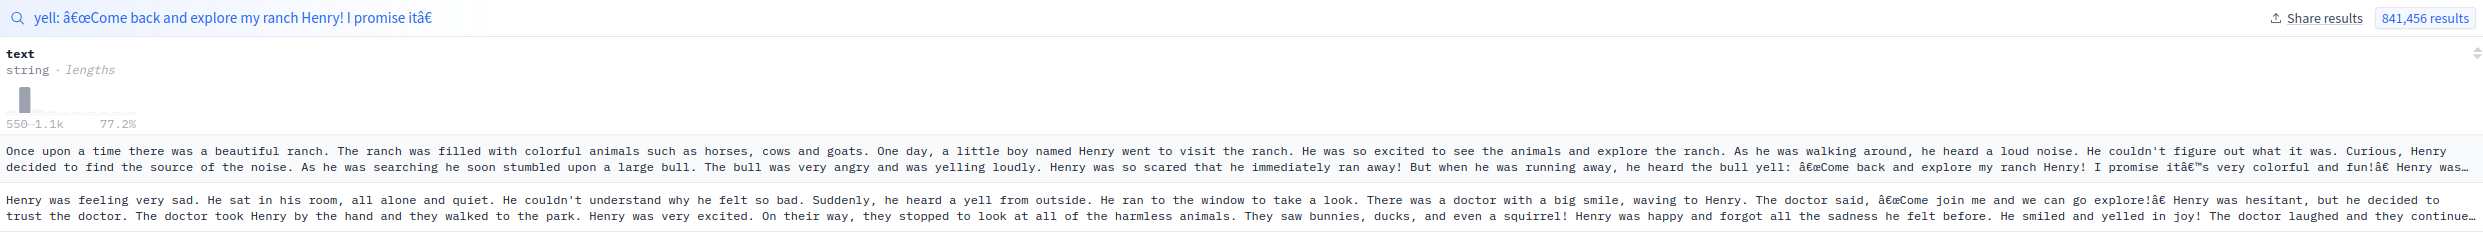

- Upon further research, I found that the issue was [brought up](https://huggingface.co/datasets/roneneldan/TinyStories/discussions/10) in the past and is likely a consequence of an encoding issue with UTF-8.  Nonetheless, I plan to dig deeper into tokenization to round off this study.

## References

Anthony, Q., Hatef, J., Narayanan, D., Biderman, S., Bekman, S., Yin, J., Shafi, A., Subramoni, H., & Panda, D. (2024). The Case for Co-Designing Model Architectures with Hardware. arXiv preprint arXiv:2401.14489. https://doi.org/10.48550/arXiv.2401.14489

Eldan, R., & Li, Y. (2023). TinyStories: How Small Can Language Models Be and Still Speak Coherent English? arXiv preprint arXiv:2305.07759.